# Facial Expression Classification with ResNet101

This notebook implements a facial expression classifier using the ResNet101 architecture. The model is trained on grayscale images converted to 3-channel format for compatibility with ResNet101.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import importlib
os.chdir('/content/drive/MyDrive/adne_imagen')

from src.dl_model_utils import *

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Configuration

In [3]:
# Configuration parameters
IMG_SIZE = (224, 224)  # ResNet101 input size
BATCH_SIZE = 16
EPOCHS = 20
FINE_TUNE_EPOCHS = 10
LEARNING_RATE = 0.0001
FINE_TUNE_LR = 1e-5
VALIDATION_SPLIT = 0.2
CHANNELS = 3  # ResNet101 expects 3 channels
MODEL_PATH = 'models/resnet101_best.keras'
FINE_TUNED_MODEL_PATH = 'models/resnet101_finetuned.keras'

## Data Loading and Preparation

We'll load the facial expression dataset and prepare it for training.

In [4]:
# Load and display dataset info
train_df = pd.read_csv("dataset/balanced_train_regruped_classes.csv")
test_df = pd.read_csv("dataset/balanced_test_regruped_classes.csv")

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("\nClass distribution in training set:")
print(train_df['Regruped Emotion'].value_counts())
print("\nClass distribution in test set:")
print(test_df['Regruped Emotion'].value_counts())

Training samples: 9000
Test samples: 2232

Class distribution in training set:
Regruped Emotion
negative    3000
neutral     3000
positive    3000
Name: count, dtype: int64

Class distribution in test set:
Regruped Emotion
negative    744
neutral     744
positive    744
Name: count, dtype: int64


In [5]:
train_df["image_path"] = train_df["image_path"].str.replace("\\", "/")
test_df["image_path"] = test_df["image_path"].str.replace("\\", "/")

## Data Generators

Set up data generators for training and validation. We'll load images as grayscale but convert them to 3-channel format for compatibility with ResNet101.

In [6]:
# Create training and validation generators using the utility function
train_gen, val_gen = get_data_generators(
    train_df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    val_split=VALIDATION_SPLIT,
    seed=RANDOM_SEED,
    x_col='image_path',
    y_col='Regruped Emotion',
    color_mode='rgb'
)

# Get test generator
test_gen = get_test_generator(
    test_df,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    x_col='image_path',
    y_col='Regruped Emotion',
    color_mode='rgb'
)

num_classes = len(train_gen.class_indices)
print("Number of classes:", num_classes)
print("Class mapping:", train_gen.class_indices)

# Input shape includes channel (3 for Resnet50)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

Found 7200 validated image filenames belonging to 3 classes.
Found 1800 validated image filenames belonging to 3 classes.
Found 2232 validated image filenames belonging to 3 classes.
Number of classes: 3
Class mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
print("Class mapping (training):", train_gen.class_indices)
print("Class mapping (validation):", val_gen.class_indices)

Class mapping (training): {'negative': 0, 'neutral': 1, 'positive': 2}
Class mapping (validation): {'negative': 0, 'neutral': 1, 'positive': 2}


## Visualize Sample Images

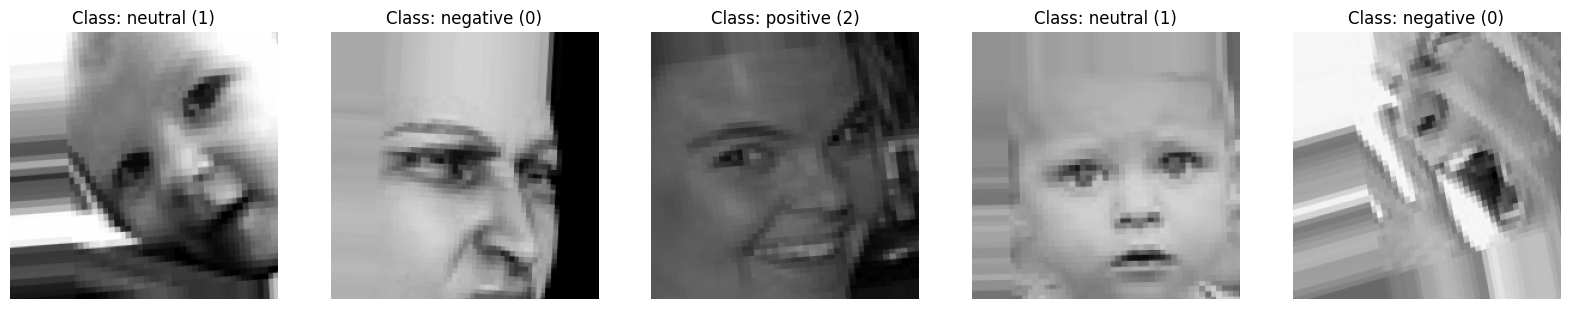

In [ ]:
# Display a few samples from the dataset to verify loading
batch_x, batch_y = next(val_gen)
plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_x[i])  # RGB images don't need reshaping

    # Since we're using categorical mode, we need to get the class index
    class_idx = np.argmax(batch_y[i])
    class_name = list(train_gen.class_indices.keys())[class_idx]
    plt.title(f"Class: {class_name} ({class_idx})")
    plt.axis('off')
plt.show()

## Build ResNet101 Model

We'll use transfer learning with a pre-trained ResNet101 model.

In [ ]:
# Create ResNet101 model using the utility function
model = build_resnet101(input_shape=input_shape, num_classes=num_classes, freeze_layers=True)

# Display model summary
model.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 45,282,691 (172.74 MB)

 Trainable params: 2,624,515 (10.01 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

## Train the Model

First, we'll train only the top layers with the pre-trained ResNet101 layers frozen.

In [ ]:
with tf.device('/GPU:0'):
    # Train model with frozen layers using the utility function
    history = train_model(model, train_gen, val_gen, epochs=EPOCHS, out_path=MODEL_PATH)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3338 - loss: 1.2325
Epoch 1: val_loss improved from inf to 1.09864, saving model to models/resnet101_best.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 4368s 10s/step - accuracy: 0.3338 - loss: 1.2324 - val_accuracy: 0.3328 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 2/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.3319 - loss: 1.0994
Epoch 2: val_loss did not improve from 1.09864
450/450 ━━━━━━━━━━━━━━━━━━━━ 219s 487ms/step - accuracy: 0.3319 - loss: 1.0994 - val_accuracy: 0.3378 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 3/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.3390 - loss: 1.1001
Epoch 3: val_loss improved from 1.09864 to 1.09863, saving model to models/resnet101_best.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 224s 498ms/step - accuracy: 0.3390 - loss: 1.1001 - val_accuracy: 0.3333 - val_loss: 1.0986 - learning_rate: 0.0010
Epoch 4/20
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.33

#### Training Results and Analysis

In the first 10 epochs of training, the model's **training accuracy** remains relatively low, around **33%**, and the **training loss** stays at approximately **1.099**. These values suggest that the model is struggling to learn effectively from the data at this stage. 

- **Validation Loss**: The validation loss (`val_loss`) improves slightly during the first few epochs, starting from **1.09864** in epoch 1 and dropping to **1.09823** by epoch 4. However, after that, it remains largely unchanged, indicating that the model is not generalizing well to the validation data. The model seems to be stuck in a local minimum, as the `val_loss` doesn't show significant improvement after epoch 4.

- **Validation Accuracy**: The **validation accuracy** (`val_accuracy`) is consistently around **33%** throughout the epochs, which is not a good indicator. This suggests that the model is struggling to predict the correct classes during validation, and may be failing to learn meaningful features from the training data.

- **Learning Rate Adjustment**: The learning rate is set to **0.001** at the start, but the model’s performance doesn’t improve much. The learning rate is dynamically reduced to **0.0002** in later epochs due to the lack of improvement in validation loss. This is likely to help avoid the model from diverging and potentially allow for better convergence in the future.

#### Conclusion

The training process indicates that the model is not learning effectively, as both the training and validation losses stagnate, and the accuracy remains low. This could be due to several factors:
- **Not fine-tuning the layers**: Since the layers have not been unfrozen yet, the model is likely not adapting well to the new dataset. Fine-tuning could help improve performance by allowing the model to adjust its pre-trained layers for the task at hand.
- **Potential issues with the learning rate**: The learning rate may still be too high or too low, and further adjustments could improve the training process.

In [ ]:
# Visualize training curves
display_training_curves(history)

## Fine-tune the Model

Now, we'll unfreeze the last 2 ResNet101 layers and fine-tune the entire model with a lower learning rate.

In [ ]:
model = load_model(MODEL_PATH)

In [ ]:
# Fine-tune the model
fine_tune_history = unfreeze_and_finetune(model, train_gen, val_gen, epochs=FINE_TUNE_EPOCHS, out_path=FINE_TUNED_MODEL_PATH)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3313 - loss: 1.0980
Epoch 1: val_loss improved from inf to 1.09705, saving model to models/resnet101_finetuned.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 3590s 8s/step - accuracy: 0.3313 - loss: 1.0980 - val_accuracy: 0.3456 - val_loss: 1.0971 - learning_rate: 1.0000e-05
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.3359 - loss: 1.0961
Epoch 2: val_loss did not improve from 1.09705
450/450 ━━━━━━━━━━━━━━━━━━━━ 208s 463ms/step - accuracy: 0.3359 - loss: 1.0961 - val_accuracy: 0.3483 - val_loss: 1.0974 - learning_rate: 1.0000e-05
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.3428 - loss: 1.0988
Epoch 3: val_loss did not improve from 1.09705
450/450 ━━━━━━━━━━━━━━━━━━━━ 209s 464ms/step - accuracy: 0.3428 - loss: 1.0988 - val_accuracy: 0.3444 - val_loss: 1.0972 - learning_rate: 1.0000e-05
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.3369 - loss: 1.0967
Epoch 4: val_lo

### Training Results and Analysis with Fine-Tuning (Last 2 Layers Unfreezed)

After fine-tuning the last two layers of the **ResNet101** model, the following observations can be made:

#### **Training Accuracy**:
- The **training accuracy** fluctuates slightly around **33-34%** during the first few epochs, with a slight increase over time.
  This suggests that the model is able to make some progress on the training set, but the learning rate might still be too low to significantly improve at a faster pace.

#### **Validation Loss and Accuracy**:
- **Validation Loss (`val_loss`)** shows a very slow improvement:
  The **`val_loss`** improved slightly after the first epoch, but the validation accuracy has stayed relatively low, indicating that the model is struggling to generalize better on the validation set. This might be due to several factors, including the complexity of the model, learning rate, or insufficient fine-tuning.

#### **Learning Rate Reduction**:
- The learning rate starts at **`1e-5`** and is reduced to **`2e-6`** by the end of the training due to the `ReduceLROnPlateau` callback. This shows that the learning rate reduction mechanism is working as expected, but the progress is slow.

#### **Key Insights**:
- **Slow Progress**: Even with the last two layers unfrozen, the training and validation accuracy have been slow to improve. This suggests that the model is not adapting well to the new dataset despite fine-tuning.
- **Small Improvements**: The **`val_loss`** improvement is small, and the **`val_accuracy`** still lags behind, which indicates that the fine-tuning of just two layers may not be sufficient.
- **Learning Rate**: The starting learning rate of **`1e-5`** may be too low to make significant progress. We might want to experiment with higher learning rates, or fine-tune the learning rate scheduler.

#### **Next Steps**:
- **Unfreeze more layers**: Fine-tuning only the last two layers might not be enough. It could be beneficial to **unfreeze more layers** in the **ResNet101** base model to allow more flexibility in learning from the dataset.
- **Increase learning rate**: Test with a higher learning rate (e.g., **`1e-4`**) at the beginning, then gradually reduce it as the model starts converging.
- **Regularization**: Consider adding **regularization techniques** (such as weight decay or batch normalization) to help improve generalization.


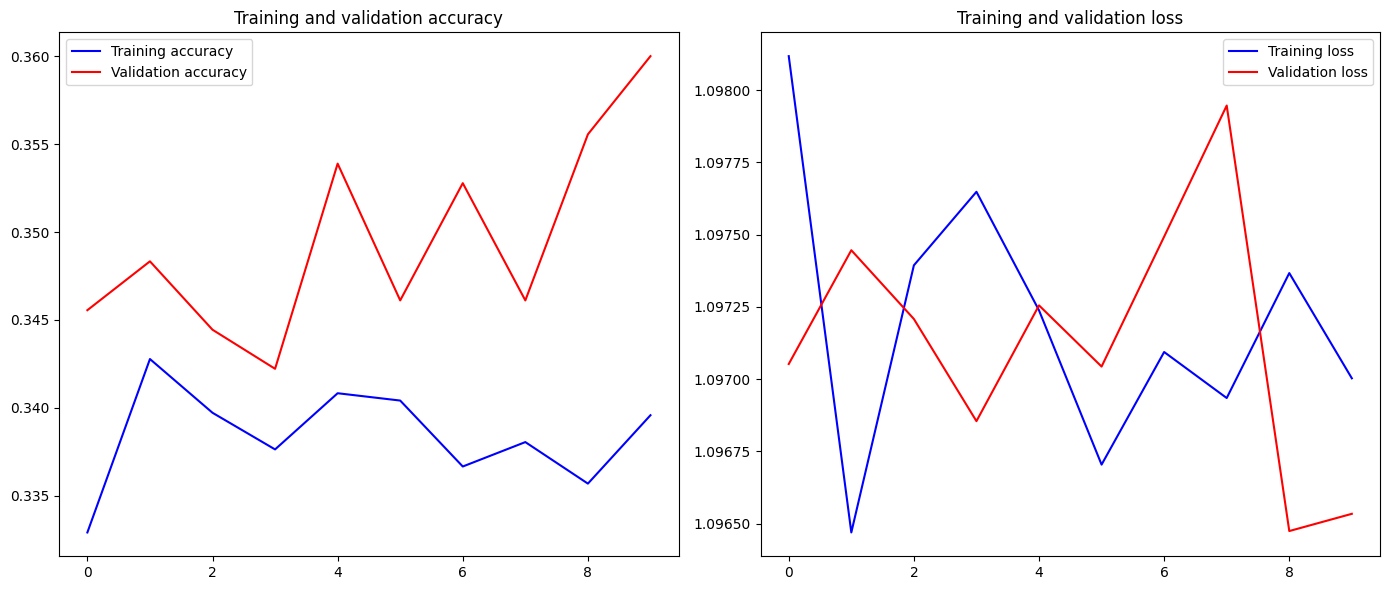

In [ ]:
# Visualize fine-tuning curves
display_training_curves(fine_tune_history)

## Evaluate Model on Test Set

In [7]:
# Load and evaluate the best fine-tuned model
final_model = load_model(FINE_TUNED_MODEL_PATH)

In [8]:
test_loss, test_acc = final_model.evaluate(test_gen)
print(f'Test accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 1104s 8s/step - accuracy: 0.3053 - loss: 1.0982
Test accuracy: 0.3405


### Test Accuracy and Analysis

After training the model, the test accuracy achieved is **34.05%**. While this represents some improvement over the initial training phase, it is still relatively low. 

- The **loss** on the test set is **1.0982**, which indicates that the model is still struggling to make meaningful predictions.
- This suggests that the model may require further fine-tuning or adjustments, such as:
  - **Unfreezing more layers** in the base model (ResNet101) to allow it to adapt better to the specific features of the dataset.
  - Experimenting with a **higher learning rate** to accelerate convergence.
  - **Adding more data augmentation** or regularization techniques to improve the generalization of the model.
  
Despite the low test accuracy, this result provides insight into areas for further experimentation, including fine-tuning more layers and adjusting hyperparameters.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


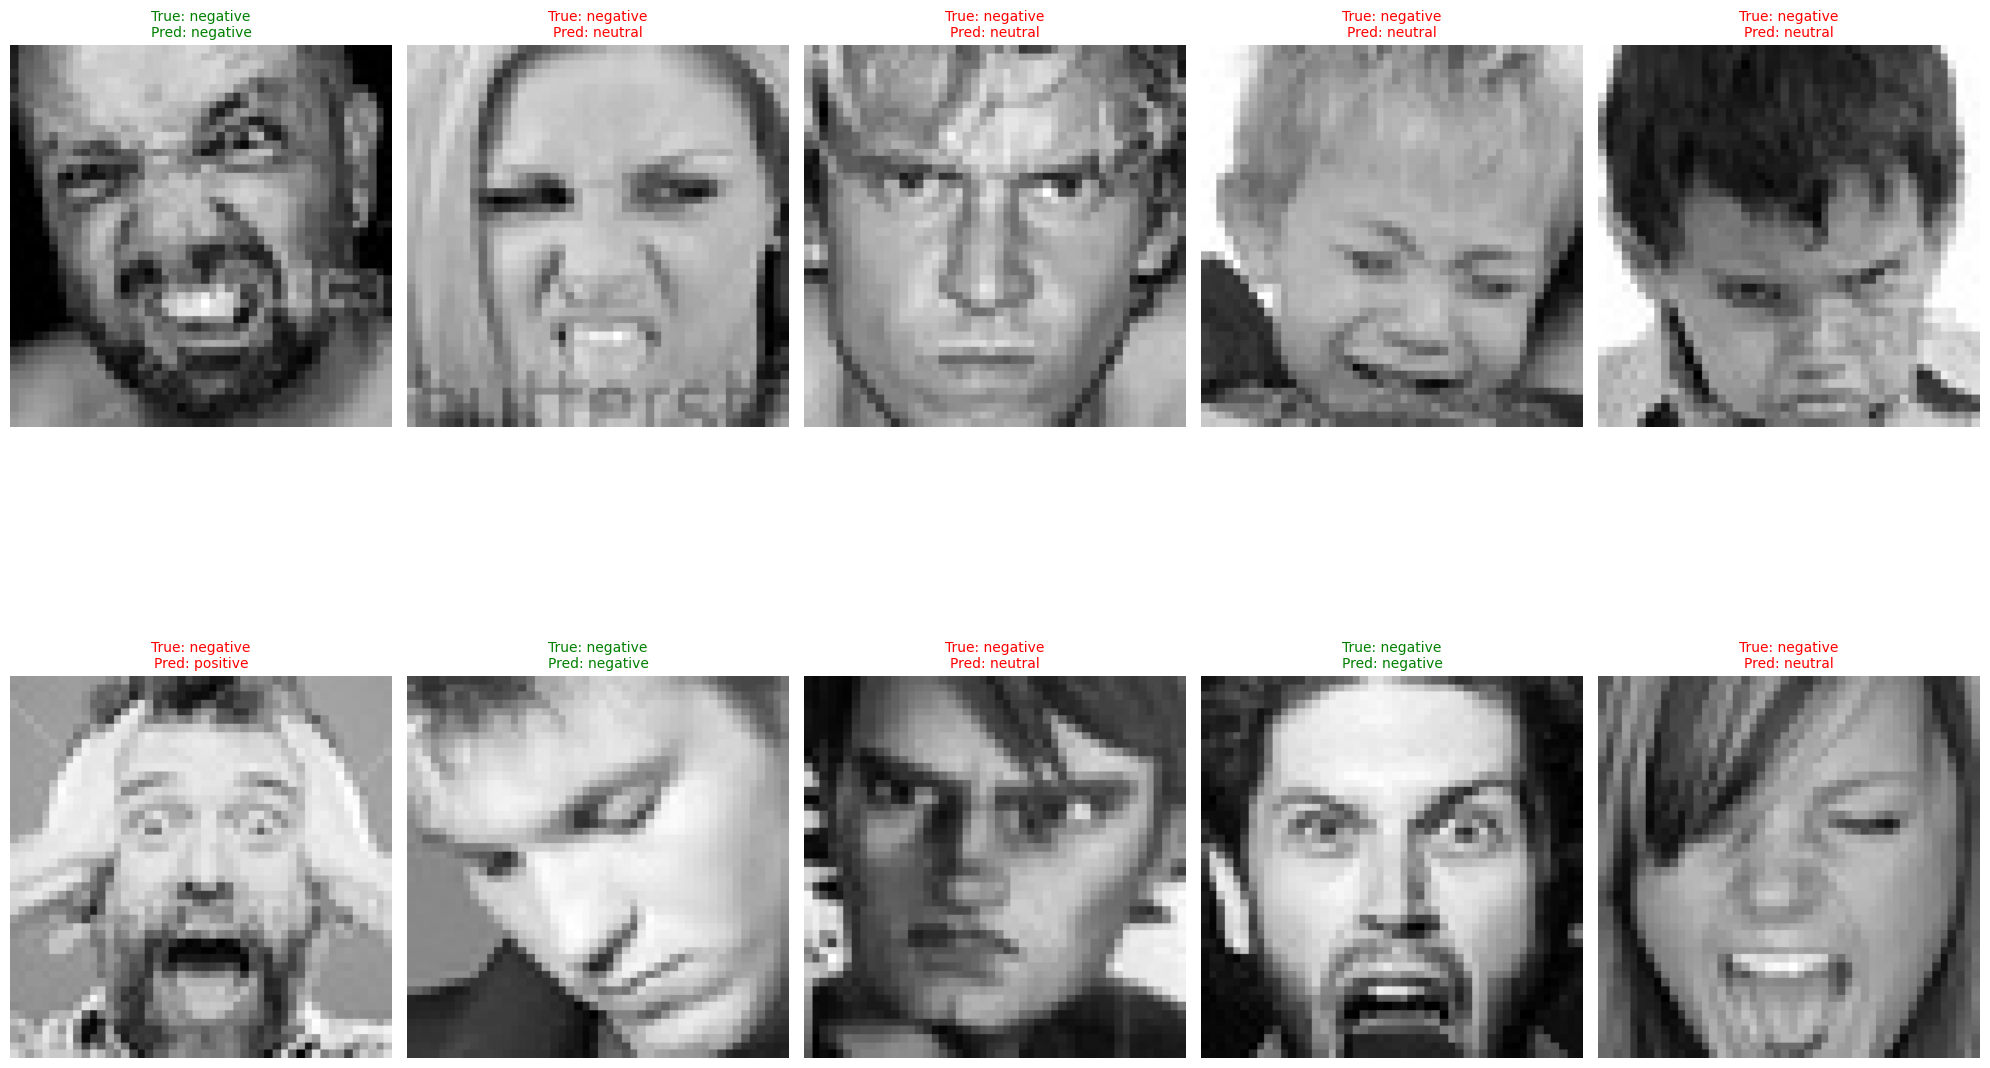

In [9]:
# Visualize some predictions
visualize_predictions(final_model, test_gen, test_gen.class_indices, num_samples=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

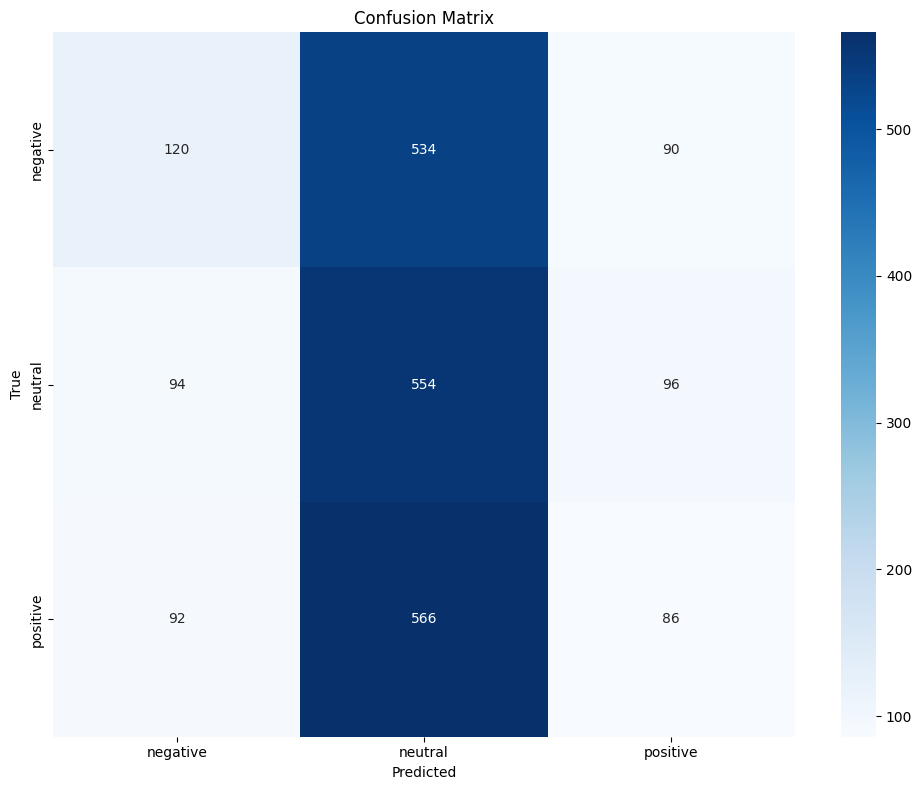

Classification Report:
              precision    recall  f1-score   support

    negative       0.39      0.16      0.23       744
     neutral       0.33      0.74      0.46       744
    positive       0.32      0.12      0.17       744

    accuracy                           0.34      2232
   macro avg       0.35      0.34      0.29      2232
weighted avg       0.35      0.34      0.29      2232

Overall Accuracy: 0.3405
Macro F1 Score: 0.2866


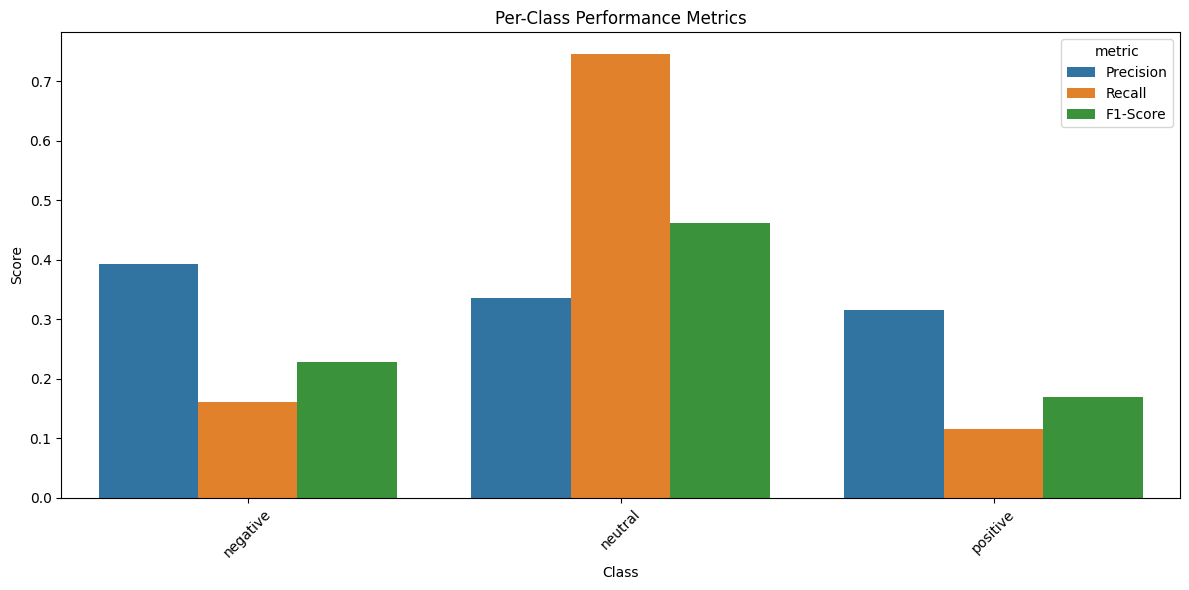

Worst performing classes by F1-score:
      Class  Precision    Recall  F1-Score
2  positive   0.316176  0.115591  0.169291
0  negative   0.392157  0.161290  0.228571
1   neutral   0.334946  0.744624  0.462052


In [10]:
# Generate confusion matrix and classification report
metrics = evaluate_model(final_model, test_gen)
print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
print(f"Macro F1 Score: {metrics['f1_macro']:.4f}")

# Get per-class metrics
class_names = list(test_gen.class_indices.keys())
class_metrics = evaluate_model_per_class(metrics, class_names)

# View the worst performing classes
print("Worst performing classes by F1-score:")
print(class_metrics.sort_values('F1-Score').head(3))

From the confusion matrix, we can observe the following key points:

The majority of predictions are classified as neutral. Specifically, the model predicts 534 instances of negative and 554 instances of neutral correctly, but it also misclassifies 120 instances of negative and 92 instances of positive as neutral.

The negative and positive classes are underrepresented in the predictions, with only a few correct predictions (120 for negative and 86 for positive), indicating that the model is not learning to distinguish these classes effectively.

This bias towards predicting neutral suggests that the model is overfitting to this class

In conclusion, the model's lack of differentiation between the classes is causing it to predict neutral overwhelmingly. We may need to adjust class weights, apply data augmentation, or fine-tune the model further to address this imbalance.